In [2]:
import sys
sys.path.insert(1, 'core')
import torch
import argparse
import net
import cv2
import os
import numpy as np
from deploy import inference_img_whole

In [3]:
    result_dir = "result/example/pred"

In [4]:
    # parameters setting
    cuda = True
    resume = "model/stage1_sad_54.4.pth"
    stage = 1
    crop_or_resize = "whole"
    max_size = 1600

In [5]:
    # init model
    model = net.VGG16(stage)
    ckpt = torch.load(resume)
    model.load_state_dict(ckpt['state_dict'], strict=True)
    model = model.cuda()

In [98]:
image_path = "Untitled Folder/06_original.jpg"
trimap_path = "Untitled Folder/mask_06_deeplabv3plus.png"#"output-Copy1.png"

In [99]:
_, image_id = os.path.split(image_path)
image = cv2.imread(image_path)
trimap = cv2.imread(trimap_path)[:, :, 0]
torch.cuda.empty_cache()
with torch.no_grad():
    pred_mattes = inference_img_whole(max_size , model, image, trimap)

In [100]:
from  PIL import Image

In [101]:
original_im = np.array(Image.open(image_path))
rows = pred_mattes.shape[0]
cols = pred_mattes.shape[1]
for x in range(0, rows):
    for y in range(0, cols):
        if pred_mattes[x][y]<0.5:
            original_im[x][y] = np.array([255, 255, 255], dtype='uint8')

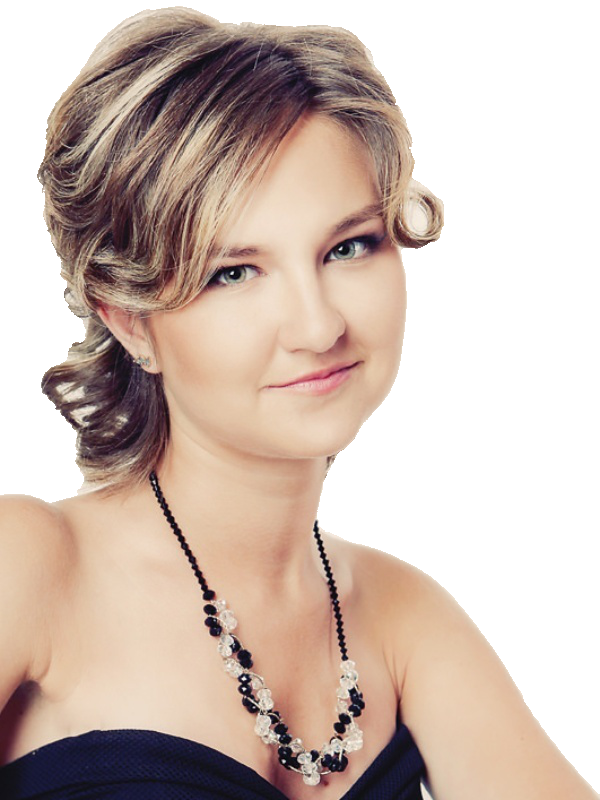

In [102]:
Image.fromarray(original_im)

In [12]:
pred_mattes[trimap == 255]

array([0.7673551 , 0.8599036 , 0.9088525 , ..., 0.9283271 , 0.94569135,
       0.97450185], dtype=float32)

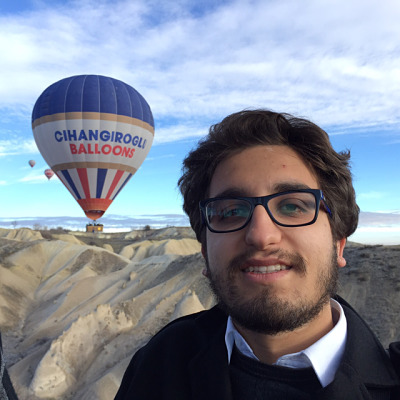

In [36]:
original_im = np.array(Image.open(image_path))
Image.fromarray(original_im)

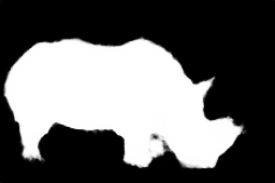

In [14]:
pred_mattes = (pred_mattes * 255).astype(np.uint8)
Image.fromarray(pred_mattes)

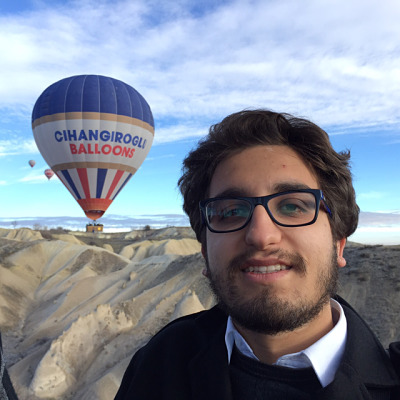

In [30]:
Image.fromarray(original_im)

In [5]:
import os
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib

from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

import tensorflow as tf

In [7]:
class DeepLabModel(object):
  """Class to load deeplab model and run inference."""

  INPUT_TENSOR_NAME = 'ImageTensor:0'
  OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
  INPUT_SIZE = 513
  FROZEN_GRAPH_NAME = 'frozen_inference_graph'

  def __init__(self, tarball_path):
    """Creates and loads pretrained deeplab model."""
    self.graph = tf.Graph()

    graph_def = None
    # Extract frozen graph from tar archive.
    tar_file = tarfile.open(tarball_path)
    for tar_info in tar_file.getmembers():
      if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
        file_handle = tar_file.extractfile(tar_info)
        graph_def = tf.GraphDef.FromString(file_handle.read())
        break

    tar_file.close()

    if graph_def is None:
      raise RuntimeError('Cannot find inference graph in tar archive.')

    with self.graph.as_default():
      tf.import_graph_def(graph_def, name='')

    self.sess = tf.Session(graph=self.graph)

  def run(self, image):
    """Runs inference on a single image.

    Args:
      image: A PIL.Image object, raw input image.

    Returns:
      resized_image: RGB image resized from original input image.
      seg_map: Segmentation map of `resized_image`.
    """
    width, height = image.size
    resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
    target_size = (int(resize_ratio * width), int(resize_ratio * height))
    resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
    batch_seg_map = self.sess.run(
        self.OUTPUT_TENSOR_NAME,
        feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
    seg_map = batch_seg_map[0]
    return resized_image, seg_map

In [8]:
    MODEL = DeepLabModel("model_xception65_coco_voc_trainval.tar.gz")
    original_im = Image.open("image_doica-Copy1.jpg")    
    width, height = original_im.size    
    resized_im, seg_map = MODEL.run(original_im)
    cm = seg_map
    img = np.array(resized_im)
    rows = cm.shape[0]
    cols = cm.shape[1]
    for x in range(0, rows):
        for y in range(0, cols):
            if cm[x][y] == 0:
                img[x][y] = np.array([0, 0, 0], dtype='uint8')
            else:
                img[x][y] = np.array([255, 255, 255], dtype='uint8')
    img = Image.fromarray(img)
    img_convert = img.resize((width, height),Image.ANTIALIAS)

In [9]:
import cv2 
def generate_trimap(alpha):
    fg = np.array(np.equal(alpha, 255).astype(np.float32))
    # fg = cv.erode(fg, kernel, iterations=np.random.randint(1, 3))
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    unknown = np.array(np.not_equal(alpha, 0).astype(np.float32))
    unknown = cv2.dilate(unknown, kernel, iterations=np.random.randint(1, 20))
    trimap = fg * 255 + (unknown - fg) * 128
    return trimap.astype(np.uint8)

array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [11]:
    img = Image.fromarray(generate_trimap(img_convert))
    img_convert = img.resize((width, height),Image.ANTIALIAS)
    img_convert.save("test.png")

In [13]:
image_path = "image_doica-Copy1.jpg"

In [17]:
_, image_id = os.path.split(image_path)
image = cv2.imread(image_path)
trimap = generate_trimap(img_convert)[:, :, 0]
torch.cuda.empty_cache()
with torch.no_grad():
    pred_mattes = inference_img_whole(max_size , model, image, trimap)

RuntimeError: CUDA out of memory. Tried to allocate 36.00 MiB (GPU 0; 31.72 GiB total capacity; 461.80 MiB already allocated; 11.88 MiB free; 14.20 MiB cached)

In [16]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='2, 3'